In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab 
import matplotlib.colors as colors
import numpy as np
import datetime as dt
import pandas as pd
import geopandas as gpd
import seaborn as sns
from scipy.stats import beta,norm,entropy,sem,pointbiserialr
import matplotlib.patches as patches
%matplotlib inline
from numpy.random import default_rng
from sklearn import metrics
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from scipy.ndimage import convolve, gaussian_filter
from sklearn.metrics import mean_squared_error, r2_score


rng = default_rng()

## Fractions Skill Score (FSS)

Evaluating forecasts that have a realistic degree of spatial and temporal variability has been a significant challenge for several decades (e.g., Anthes 1983; Davis and Carr 2000; Ebert 2008; Gilleland et al. 2009; Dorninger et al. 2018). The “double penalty” issue arises with even slight imperfections in forecasts that contain realistic variability, where measures related to the difference between observed and predicted values will penalize the forecast for predicting an event where it did not occur and again for not predicting an event where it did occur. Numerous approaches for evaluating realistic forecasts have been developed, which can generally be categorized as multiscale analysis methods (e.g., Casati et al. 2004, Harris et al. 2001), feature-based (e.g., Ebert and McBride 2000; Davis et al. 2006), field deformation (e.g., Hoffman et al. 1995; Marzban et al. 2009), and neighborhood approaches (Ebert 2008; Ebert 2009) Of these, the Fractions Skill Score (Roberts and Lean 2008) has emerged as one of the most widely-used approaches for measuring the performance of realistic spatial forecast fields. (Google Scholar shows that it has been cited in 1500+ papers)

The "neighborhood" approach is designed to give credit to imperfect but “useful” forecasts, for instance forecasts that contain realistic variability along with some displacement in time or space. Neighborhood methods measure the accuracy/skill of the forecasts within "windows" in space and/or time. Roberts and Lean (2008) expressed the motivation for this approach in terms of determining the scale(s) at which forecasts become useful: “Techniques are required that can evaluate scales at which forecasts become sufficiently skillful and identify the scales over which increased resolution is beneficial (if any).” 

### FSS definition

Roberts and Lean (2008) defined FSS by creating a skill score that normalizes the mean squared error (also called the Fractions Brier Score or FBS, Roberts and Lean 2008) with a reference forecast that has the “largest possible MSE than can be obtained from the forecast and observed fractions” (Roberts and Lean 2008) for each neighborhood window. To calculate FSS, observed and forecasted fields are thresholded to produce binary values. The neighborhood approach proceeds by generating forecasted and observed “fractions” through the calculation of the fraction of grid cells having a value of 1 within a window or neighborhood, or a simple average of the binary values within a “n x n” square window. (other window shapes can be used, such as circular) The normalized mean squared error of these fractions is typically calculated for monotonically increasing neighborhood/window sizes, potentially until the averaging reaches the size of the full spatial domain of the forecast system. 

Since these fractions are similar to probabilities, we will use the same notation that Murphy (1988) used to analyze MSE-based measures for probability forecasts. The fraction of forecast values for the n-th neighborhood window at the i-th location/time will be denoted as $f_i[n]$, while the fraction of observed values for the n-th neighborhood window at the i-th location/time will be denoted as $x_i[n]$. To simplify the notation, we will drop the $[n]$ scripting, recognizing that each of these terms are calculated for each neighborhood averaging window size. FSS for the n-th neighborhood window is computed over all locations/times:

\begin{equation}
FSS=1-\frac{\frac{1}{N}\sum(f_i-x_i)^2}{\frac{1}{N}\sum(f_i)^2+\frac{1}{N}\sum(x_i)^2}
=1-\frac{FBS}{FBS_{ref}}
\end{equation}

\begin{equation}
FBS=\frac{1}{N}\sum(f_i-x_i)^2=\frac{1}{N}\sum(f_i)^2+\frac{1}{N}\sum(x_i)^2-\frac{2}{N}\sum(f_i x_i)
\end{equation}

\begin{equation}
FBS_{ref}=\frac{1}{N}\sum(f_i)^2+\frac{1}{N}\sum(x_i)^2
\end{equation}

By completing the square in the numerator, mean squared error (FBS) can be expressed in terms of the second moments along with the product moment of the forecasts and observations. The reference FBS was defined as the forecast with the “largest possible MSE”, by setting the product moment of the forecasts and observations to zero, at the grid scale this is effectively the same as a forecast with zero overlap with the observations. 

### Issues with FSS

In previous work, several authors have raised issues with this score. While technically a skill score, it does not behave like a typical measure of skill. Mittermaier (2021) discussed issues with calculating summary FSS values over a large set of cases, especially those containing correct forecasts of zero precipitation over the domain. FSS is highly sensitive to frequency bias. While a perfect forecast will have FSS=1, Roberts and Lean (2008) show that the "asymptotic" value of FSS will be equal to 1 only if the forecasts are unbiased. Skok and Roberts (2018) discuss the FSS's significant sensitivity to bias, and mention that "in cases with a large bias, the FSS will never reach the value of 0.5" which many authors choose as the threshold for determining the scale of "useful" forecasts. Skok (2015), Mittermaier (2021), and Antonio and Aitchison (2025) each discuss issues with the assumption that the FSS=0.5 threshold indicates that the forecasts become "skillful" or "useful" and the dependence of this on the observed event frequency. 

It is also problematic to consider values of FSS=0 as indicating "no skill", for instance Antonio and Aitchison (2025) show that at the grid scale, FSS for a random forecast is >0 and equal to the observed event frequency. Skok and Roberts (2016) showed that FSS increased monotonically with increasing neighborhood size for random forecasts. Antonio and Aitchison (2025) derived an expression for the expected value of FSS for a random forecast for any neighborhood scale, which increases with increasing neighborhood scale. They recommend providing this "random" value of FSS as a baseline in order to properly measure "skill" using FSS.

FSS was derived using the “worst possible” forecast as the reference, which Mittermaier (2021) explained was not always possible, especially for relatively high observed event frequencies. Many standard approaches that have traditionally been considered to have “no skill” (such as random chance) will display “positive” skill in terms of FSS. Unfortunately, the information required to determine the level of accuracy of the “reference” forecast is not always provided when measures of skill are reported. As we will find, this is especially problematic for FSS since the behavior of the reference forecast does not remain consistent as the neighborhood window size increases.


### Implications of the FSS reference forecast

Measures of skill are typically derived by normalizing a measure of accuracy (or error) in such a way that the numerical value of the measure varies from zero to one between forecasts considered to have “no skill” and perfect forecasts. The “no skill” baseline is defined as a forecast system with accuracy equal to a standard or “reference” approach, such as random chance, climatology, persistence, or a constant (such as “all no” or “all yes”). The choice of reference forecast is an important issue in understanding a quantitative measure of skill. For example, the traditional form of the Brier skill score (BSS) was derived using an unbiased single-valued (constant) reference forecast (Murphy 1974) equal to the observed event frequency from the verification sample. There are several studies (e.g., Murphy 1988; Mason 2004; Hamill and Juras 2006) that have noted issues with using single-valued reference forecasts to quantify skill, particularly when the verification dataset is aggregated over pooled subsets that have different base rates or forecast variances. Rather than a constant reference forecast, many other traditional skill scores were defined using “random chance” as the reference forecast (e.g., Gilbert 1884; Peirce 1884; Doolittle 1885; Heidke 1925; Doswell et al. 1990; Schaefer 1990).

To better understand the implications of using the "largest possible MSE" forecast as the "no skill" reference baseline in FSS, we will use a standard decomposition of MSE (Murphy 1988) and substitude the definitions of the sample means, variances, and covariance of the forecast and observed fractions:

$\bar x=\frac{1}{N}\sum x_i$

$\bar f=\frac{1}{N}\sum f_i$

$s_x^2=\frac{1}{N}\sum(x_i)^2-(\frac{1}{N}\sum x_i)^2$

$s_f^2=\frac{1}{N}\sum(f_i)^2-(\frac{1}{N}\sum f_i)^2$

$s_{fx}=\frac{1}{N}\sum(f_i x_i)-(\frac{1}{N}\sum f_i)(\frac{1}{N}\sum x_i)$

$FBS=s_f^2+s_x^2+(\bar f)^2+(\bar x)^2-2s_{fx}-2\bar f \bar x$

$FBS_{ref}=s_f^2+s_x^2+(\bar f)^2+(\bar x)^2$

The reference forecast is defined as fractions within the same neighborhood size with the same distribution (mean and variance) as the forecast being evaluated. Therefore, in order to achieve this “largest possible” value of $FBS_{ref}$, the last two terms in the FBS decomposition must cancel out (assuming we have non-zero means $\bar f \gt 0$ and $\bar x \gt 0$). In order for those terms to cancel, the reference forecast system must effectively have a negative value of covariance, equal in magnitude to the product of the forecast and observed means.

${s_{fx}}_{ref}=- \bar f \bar x$

This can be expressed in terms of the correlation coefficient for the reference forecast:
\begin{equation}
{r_{fx}}_{ref}=\frac{{s_{fx}}_{ref}}{s_f s_x}=-\frac{\bar f \bar x}{s_f s_x}
\end{equation}

Since these terms can change with neighborhood size, we immediately find that the behavior of the FSS reference forecast is inconsistent as the neighborhood window increases, and rapidly becomes unachievable. The fractions means in the numerator are typically assumed to be constant with neighborhood window size, although in practice this will depend on the method used to calculate the fractions near the edges of the spatial domain (Antonio and Aitchison (2025) recommend using a reflective convolution approach to maintain constant means). However, we should anticipate that the variances of the fractions fields in the denominator will decrease monotonically as the scale of the neighborhood averaging window increases, starting at the largest value at the grid scale (where the forecasts and observations are binary), eventually vanishing when the averaging neighborhood reaches the size of the full domain. As a result, the effective correlation coefficient for the reference forecast must become *increasingly more negative* as the neighborhood size increases. At some point, the magnitude of the variances will fall below the means, pushing the effective correlation of the reference forecast below -1, making the reference forecast *impossibly bad*. 


In summary, the reference forecast used in FSS gets increasingly worse as the neighborhood window gets larger and eventually becomes worse than any real forecast can possibly achieve. Since this reference establishes the FSS=0 baseline, we should expect to see *all* forecasts to display increasing FSS with neighborhood size, even those that are typically considered to have “no skill” such as random chance.

### FSS decomposition

Antonio and Aitchison (2025) showed that FSS could be decomposed in terms of the means and variances of the forecast and observed fractions along with the correlation coefficient between the forecast and observations. Another way to look at this is that FSS is the harmonic mean of the product moment of forecasts and observations, normalized by the second moments of the forecasts and observations.

\begin{equation}
FSS=\frac{2r_{fx} s_f s_x+2 \bar f \bar x}{s_f^2+s_x^2+{\bar f}^2+{\bar x}^2}=\frac{2\frac{1}{N}\sum(f_i x_i)}{\frac{1}{N}\sum(f_i)^2+\frac{1}{N}\sum(x_i)^2}
=HM(\frac{\frac{1}{N}\sum(f_i x_i)}{\frac{1}{N}\sum(f_i)^2},\frac{\frac{1}{N}\sum(f_i x_i)}{\frac{1}{N}\sum(x_i)^2})
\end{equation}

We can decompose FSS further by substituting the defintion of the frequency bias $B=\frac{\bar f}{\bar x}$:

\begin{equation}
FSS=r_{fx}\frac{2 s_f s_x}{(s_f^2+s_x^2)+(B^2+1){\bar x}^2}+\frac{2 B {\bar x}^2}{(s_f^2+s_x^2)+(B^2+1){\bar x}^2}
\end{equation}

We find that FSS is a function of the correlation between forecasted and observed fractions ($r_{fx}$), the variances of the fractions fields ($s_f^2$,$s_x^2$), frequency bias ($B$), and the base rate ($\bar x$). In particular, note that FSS is the sum of two terms, only one of which includes some measure of the degree of correspondence between the forecasts and observations. Since the first term includes the correlation coefficient we will denote it as the “skillful” component of FSS. Going forward, we will consider a forecast with zero correlation to the observations to be “random”. Since the second term can be non-zero when $r_{fx}=0$, it will be called the “random” component of FSS. FSS is the sum of these “skillful” and “random” components.

### Simplified FSS decomposition

In order to better understand the scale-dependent behavior of FSS, we will consider how each of the terms in the FSS decomposition can vary with increasing neighborhood averaging window size. The neighborhood approach is designed to give credit to imperfect but “useful” forecasts, for instance forecasts that contain realistic variability along with some displacement in time or space. In such cases, one would expect the correlation between the forecast and observed fractions to increase as the neighborhood scale increases. However, this will not necessarily be the case, correlation could decrease or remain nearly constant with increasing scale (Antonio and Aitchison 2025 show examples where correlation decreases and then increases with neighborhood size). As previously discussed, the fractions means (which appear as the base rate and frequency bias here) are typically assumed to be constant with window size, and we expect that the variances of the fractions fields will decrease monotonically as the scale of the neighborhood averaging window increases. These terms are found in both the numerator and denominator of the expression, complicating the analysis of the behavior of FSS with increasing neighborhood scale.

At this point we will simplify the expression further by considering the situation when the variances of the forecasted and observed fractions are approximately the same ($s_f^2\approx s_x^2$) and the forecast is unbiased ($B=1$). This simplified version of FSS is expressed terms of the forecast/observation correlation coefficient, variance of the fractions, and the base rate;

\begin{equation}
FSS \approx r_{fx}\frac{s_x^2}{s_x^2+{\bar x}^2}+\frac{{\bar x}^2}{s_x^2+{\bar x}^2}
\end{equation}

This simplified expression allows us to anticipate how the “skillful” and “random” components of FSS will change with neighborhood scale. The variance of the fractions will decrease monotonically as the scale of the neighborhood averaging window increases, starting at the largest value at the grid scale (binary fields: $s_x^2=\bar x(1-\bar x)$), vanishing when the neighborhood reaches the size of the full domain. At the same time, we expect that the base rate will remain constant with increasing neighborhood scale. As a result, the denominator in both terms will start at the largest value at the grid scale (for binary fields  $s_x^2+{\bar x}^2=\bar x$) and approach the square of the base rate as the scale of the neighborhood window increases. The numerator of the “skillful” term will decrease monotonically, eventually reaching zero when the neighborhood reaches the size of the full domain. Therefore, we should expect that the “skillful” component of FSS will *decrease monotonically* with increasing neighborhood scale. On the other hand, the numerator in the “random” term remains constant, so we should expect the “random” component will *increase monotonically* with increasing neighborhood scale, approaching a value of one for an unbiased forecast (or the asymptotic value $FSS_{asym}=\frac{2 B}{B^2+1}$) for a biased forecast, Roberts and Lean 2008). Since FSS is the sum of these two terms, we should expect FSS will generally *increase* with neighborhood size and approach a relatively high value at large neighborhood window scales *regardless of the degree of correlation between the forecasts and observations*. This is problematic behavior for a measure of forecast skill.

### 1-D example

This can be illustrated further with a simple example. Rather than two-dimensional grids, one-dimensional arrays will be analyzed. One can imagine using FSS to evaluate predicted and observed time series of an event at a single location, or the occurrence of an event along a path. Synthetic fields are generated using a simple autoregressive process of order 1 ($x_i= \phi x_{i-1}+\epsilon_i$, see sample_signal function) with a specified level of autocorrelation. For the observations, a sample of 100000 points is generated and converted to a binary field using a percentile threshold at a specific event frequency (in the results that follow, $\bar x=0.1$), which will maintain some of the autocorrelation in the original AR(1) process. A synthetic “skillful” forecast is generated by shifting the original AR(1) signal by a fixed number of points, smoothing it with a gaussian filter (sigma=3.), and adding “random error” generated by a separate AR(1) process. A “random” forecast is generated by a random number generator. Binary forecasts are produced using the same percentile threshold to generate unbiased forecasts ($\bar f=0.1$). Fractions fields are computed using neighborhood windows of increasing widths applied using a 1-D convolution with equal weights and a “reflective’” mode at the edges of the domain. 

Text(0.5, 1.0, '1-D example $\\bar x$ = 0.1 $\\bar f$ = 0.1')

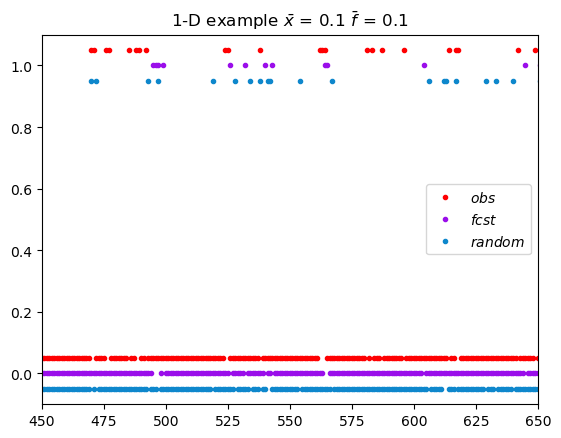

In [11]:
def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

colorlist=['xkcd:fire engine red','xkcd:violet','xkcd:water blue','xkcd:medium green','xkcd:dark purple','xkcd:burnt sienna','xkcd:orange']

nn=100000
ishif=3
xbar1=0.1
fbar1=0.1
corr=0.5
corr_noise=0.35

sample=sample_signal(nn, corr)
fcsta=gaussian_filter(np.roll(sample,ishif),3.,mode='reflect')+sample_signal(nn, corr_noise)*0.5
randsample=rng.random(nn)

thr=np.quantile(sample,1.-xbar1)
obs1=(sample>=thr)*1.0
thrf=np.quantile(fcsta,1.-fbar1)
fcst1=(fcsta>=thrf)*1.0
thrr=np.quantile(randsample,1.-xbar1)
rand1=(randsample>=thrr)*1.0

# plot a subset of the data
xplot=np.arange(100000)
plt.plot(xplot,obs1+0.05,'.',c=colorlist[0],label=r'$obs$')
plt.plot(xplot,fcst1,'.',c=colorlist[1],label=r'$fcst$')
plt.plot(xplot,rand1-.05,'.',c=colorlist[2],label=r'$random$')
plt.legend(loc='center right')
plt.xlim(450.,650.)
plt.ylim(-0.1,1.1)
plt.title(r'1-D example $\bar x$ = '+f'{xbar1}'+r' $\bar f$ = '+f'{fbar1}')

### calculate FSS for this example

The plot above shows a small subset of the domain (N=100000) with a small offset in the observations and random forecast values to allow for easier visual comparison. The observations show some degree of autocorrelation with blocks of consecutive points having similar values, while the forecasts appear to have a higher degree of autocorrelation with larger blocks of contiguous values and appear to be shifted to the right relative to the observations. The random forecast appears more intermittent than the observations or the skillful forecast.

The code below computes the fractions of the observations, skillful forecast, and random forecast. The "convolve" function from scipy.ndimage ('reflective' mode as recommended by Antonio and Aitchison 2025) is used to calculate the fractions across a range of neighborhood window sizees. A variety of statistics are calculated for each neighborhood scale, including FSS and correlation coefficient. 

In [10]:
# calculate FSS and various stats across a range of 1-D neighborhood windows
# using 'reflective' convolution from scipy.ndimage

fss=np.zeros(75)
pofd=np.zeros_like(fss)
fss=np.zeros_like(fss)
mse1=np.zeros_like(fss)
sf_2=np.zeros_like(fss)
sx_2=np.zeros_like(fss)
sf_x=np.zeros_like(fss)
sf_2_rand=np.zeros_like(fss)
sx_2_rand=np.zeros_like(fss)
sf_x_rand=np.zeros_like(fss)
fbar_1=np.zeros_like(fss)
fbar_rand=np.zeros_like(fss)
xbar_1=np.zeros_like(fss)
nwin=np.zeros_like(fss)
fss_rand=np.zeros_like(fss)
rfx1=np.zeros_like(fss)
rfx2=np.zeros_like(fss)

for n in np.arange(fss.shape[0]):
    iwin=n*4+1         # neighborhood window size in terms of grid points
    win=iwin*1.0
    obs2=convolve(obs1,np.ones(iwin)/win,mode='reflect')     # use convolution to calculate the fractions
    fcst2=convolve(fcst1,np.ones(iwin)/win,mode='reflect')
    rand2=convolve(rand1,np.ones(iwin)/win,mode='reflect')
    # compute various stats from the fractions
    nwin[n]=iwin
    sx_2[n]=np.var(obs2)
    sf_2[n]=np.var(fcst2)
    xbar_1[n]=np.mean(obs2)
    fbar_1[n]=np.mean(fcst2)
    sf_x[n]=np.cov([obs2,fcst2])[0][1]
    sx_2_rand[n]=np.var(obs2)
    sf_2_rand[n]=np.var(rand2)
    fbar_rand[n]=np.mean(rand2)
    sf_x_rand[n]=np.cov([obs2,rand2])[0][1]
    fss[n]=1.-np.sum((fcst2-obs2)**2.)/(np.sum(fcst2**2.)+np.sum(obs2**2.))
    fss_rand[n]=1.-np.sum((rand2-obs2)**2.)/(np.sum(rand2**2.)+np.sum(obs2**2.))
    rfx1[n]=np.corrcoef([obs2,fcst2])[0][1]
    rfx2[n]=np.corrcoef([obs2,rand2])[0][1]

### plot FSS, normalized sharpness, and correlation vs neighborhood size

The code below generates a plot of FSS versus neighborhood window size and compares the skillful forecast to the random forecast in the left subplot. Since the FSS decomposition showed that FSS is a function of correlation, variances, event frequency, and bias (in this example the forecasts are unbiased $B=1$) we will follow Antonio and Aitchison (2025) and plot the correlation coefficient and normalized sharpness ($s_f$/$s_x$) in the right subplot.

(0.0, 121.0)

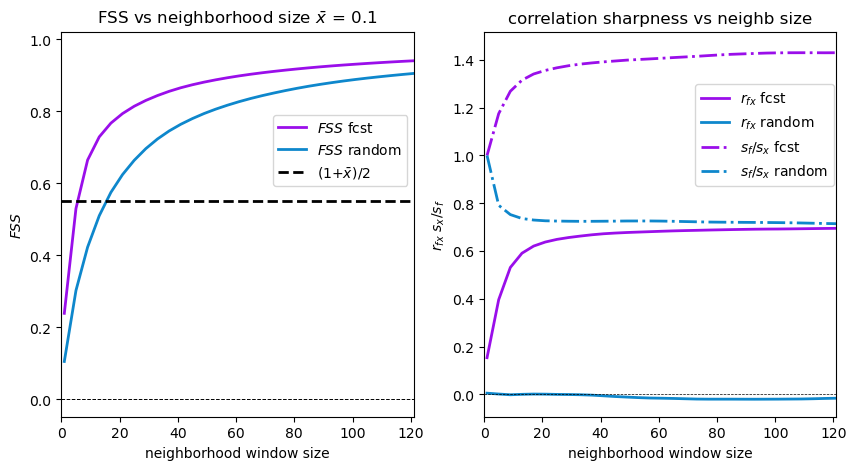

In [73]:
# FSS on the left subplot, correlation and normalized sharpness on the right subplot
# following Antonio and Aitchison (2025)
xbar=np.mean(obs1)

fig,ax = plt.subplots(1,2,figsize=(10,5))
axs=ax.flat
axs[0].plot(nwin,fss,c=colorlist[1],lw=2.,label=r'$FSS$ fcst')
axs[0].plot(nwin,fss_rand,c=colorlist[2],lw=2.,label=r'$FSS$ random')
axs[0].plot([0.,400.],[0.55,0.55],c='k',ls='--',lw=2.,label=r'(1+$\bar x$)/2')
axs[0].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.7)
axs[0].legend(loc=[0.6,0.6])
axs[0].set_xlabel('neighborhood window size')
axs[0].set_ylabel(r'$FSS$')
axs[0].set_title(r'FSS vs neighborhood size $\bar x$ ='+f' {np.round(xbar,2)}')
axs[0].set_xlim(0.,121.)

axs[1].plot(nwin,rfx1,c=colorlist[1],lw=2.,label=r'$r_{fx}$ fcst')
axs[1].plot(nwin,rfx2,c=colorlist[2],lw=2.,label=r'$r_{fx}$ random')
axs[1].plot(nwin,np.sqrt(sf_2)/np.sqrt(sx_2),c=colorlist[1],lw=2.,ls='-.',label=r'$s_f$/$s_x$ fcst')
axs[1].plot(nwin,np.sqrt(sf_2_rand)/np.sqrt(sx_2_rand),c=colorlist[2],lw=2.,ls='-.',label=r'$s_f$/$s_x$ random')

axs[1].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.5)
axs[1].legend(loc=[0.6,0.6])
axs[1].set_xlabel('neighborhood window size')
axs[1].set_ylabel(r'$r_{fx}$ $s_x$/$s_f$')
axs[1].set_title(r'correlation sharpness vs neighb size')
axs[1].set_xlim(0.,121.)



For the skillful forecast in this example, $FSS$ increases sharply with increasing neighborhood window size, exceeding what is typically used as the baseline for determining the scale for "useful" forecasts indicated by the dashed black line (defined by Roberts and Lean (2008) as "halfway between random forecast skill and perfect skill" which they denoted as $FSS_{uniform}=(1+\bar x)/2$) for a neighborhood window between 5 and 9 points in size. However, the randomly-generated forecast also displays FSS increasing as the neighborhood window size increases, in this case exceeding the typical baseline for neighborhood window sizes beyond 17 grid points. For both of the forecasts in this example, $FSS$ continues to increase and approach the "asymptotic" value of 1 that is expected for unbiased forecasts (Roberts and Lean 2008). Antonio and Aitchison (2025) recommended using $FSS$ from a random unbiased forecast with no autocorrelation as the "reference" score curve when analyzing $FSS$, and we see in this example that the skillful forecast has $FSS$ values greater than the random forecast across all neighborhood window sizes.

In the right-hand subplot we see that the correlation coefficient for the skillful forecast also increases sharply with increasing neighborhood size before reaching a plateau near $r_{fx} \approx 0.7$ for windows greater than ~40 grid points in size. This sharp increase might be expected from a forecast this is generally shifted relative to the observations (although this forecast also contains random error). On the other hand, the random forecast shows nearly zero correlation with the observed fractions across the entire range of neighborhood window sizes. Since both the skillful and random forecast show monotonically increasing $FSS$ scores, it is difficult to find a signal of a "plateau" in performance (or the window size where that begins) in the skillful forecast by analyzing the $FSS$ values alone.

The normalized sharpness ($s_f$/$s_x$) for both of the example forecasts start with a value of 1 at the grid scale, which is expected for an unbiased binary forecast ($\bar f = \bar x$, $s_f^2 = s_x^2 = \bar x (1 - \bar x)$). As the neighborhood averaging window size increases, the normalized sharpness of the skillful forecast increases, while the sharpness for the random forecast decreases, before both reach nearly constant values beyond window sizes of approximately 40 and larger. The change of sharpness with increasing averaging scale provides information about the multi-scale structure of the forecast fraction fields compared to the observed fields. We'll find more evidence of this by analyzing the variances of the fractions in the plots below.

(0.0, 121.0)

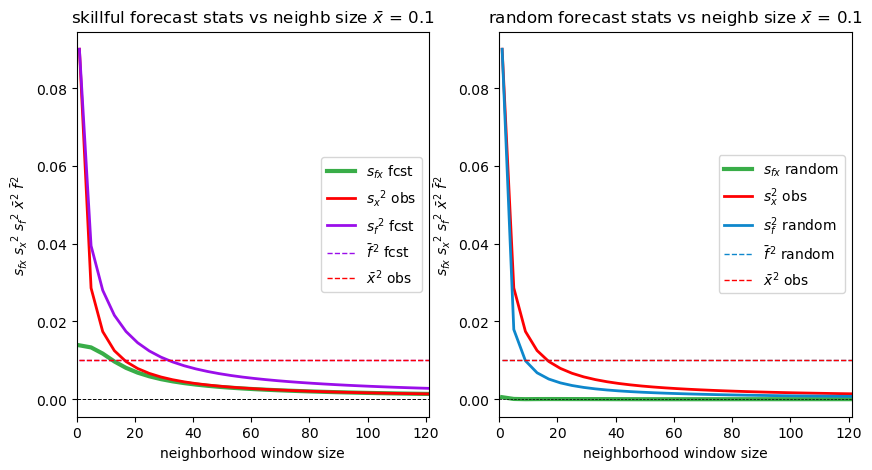

In [45]:
# compare the skillful forecast on the left-hand subplot to the random forecast in the right-hand subplot
xbar=np.mean(obs1)

fig,ax = plt.subplots(1,2,figsize=(10,5))
axs=ax.flat
axs[0].plot(nwin,sf_x,c=colorlist[3],lw=3.,label=r'$s_{fx}$ fcst')
axs[0].plot(nwin,sx_2,c=colorlist[0],lw=2.,label=r'${s_x}^2$ obs')
axs[0].plot(nwin,sf_2,c=colorlist[1],lw=2.,label=r'${s_f}^2$ fcst')
axs[0].plot(nwin,fbar_1*fbar_1,c=colorlist[1],lw=1.,ls='--',label=r'$\bar f^2$ fcst')
axs[0].plot(nwin,xbar_1*xbar_1,c=colorlist[0],lw=1.,ls='--',label=r'$\bar x^2$ obs')
axs[0].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.7)
axs[0].legend(loc='center right')
axs[0].set_xlabel('neighborhood window size')
axs[0].set_ylabel(r'$s_{fx}$ ${s_x}^2$ ${s_f}^2$ $\bar x^2$ $\bar f^2$')
axs[0].set_title(r'skillful forecast stats vs neighb size $\bar x$ ='+f' {np.round(xbar,2)}')
axs[0].set_xlim(0.,121.)

axs[1].plot(nwin,sf_x_rand,c=colorlist[3],lw=3.,label=r'$s_{fx}$ random')
axs[1].plot(nwin,sx_2_rand,c=colorlist[0],lw=2.,label=r'$s_x^2$ obs')
axs[1].plot(nwin,sf_2_rand,c=colorlist[2],lw=2.,label=r'${s_f^2}$ random')
axs[1].plot(nwin,fbar_rand*fbar_rand,c=colorlist[2],lw=1.,ls='--',label=r'$\bar f^2$ random')
axs[1].plot(nwin,xbar_1*xbar_1,c=colorlist[0],lw=1.,ls='--',label=r'$\bar x^2$ obs')
axs[1].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.5)
axs[1].legend(loc='center right')
axs[1].set_xlabel('neighborhood window size')
axs[1].set_ylabel(r'$s_{fx}$ ${s_x}^2$ ${s_f}^2$ $\bar x^2$ $\bar f^2$')
axs[1].set_title(r'random forecast stats vs neighb size $\bar x$ ='+f' {np.round(xbar,2)}')
axs[1].set_xlim(0.,121.)



### analyze FSS components vs neighborhood window size

We'll look at how each of the FSS components in the Antonio and Aitchison (2025) decomposition vary with increasing neighborhood window size.
\begin{equation}
FSS=\frac{2r_{fx} s_f s_x+2 \bar f \bar x}{s_f^2+s_x^2+{\bar f}^2+{\bar x}^2}
=\frac{2s_{fx}+2 \bar f \bar x}{s_f^2+s_x^2+{\bar f}^2+{\bar x}^2}
\end{equation}

As expected, the variances of the forecast and observed fractions decrease monotonically as the neighborhood window size increases. Analyzing the rate at which the variance of the field decreases with increasing averaging scale was called "moment-scale" analysis by Harris et al. (2001), who showed that this type of analysis provides information about the degree of "intermittency" in a field. A highly intermittent field will have localized peaks and sharp gradients, which will diminish as they are averaged across larger neighborhood windows. For more contiguous/less intermittent fields, "peaks" are spread across multiple grid boxes, so the averaging will have less of an effect since higher values will remain located near other high values of the field even as the averaging scale increases. Comparing these  scale-dependent statistics of the forecasts compared to the observations can give us insight into the relative degree of "realism" in the forecast fields.

In the skillful forecast example on the left, the variance of the forecast (purple) decreases with neighborhood size at a reduced rate compared the observed fractions (red). In this case, the forecasts were generated by smoothing the observed field and shifting it by a few grid boxes, the smoothing resulted in a field with more autocorrelation/less intermittency. The more "contiguous" blocks of binary forecast points will maintain higher values of the fractions when compared to the more intermittent observed fractions as the neighborhood averaging process continues, so we should expect the variance of those forecast fractions to remain larger than the observed variance as the neighborhoods get larger (normalized sharpness > 1). We also see that the forecast/observation covariance decreases as the neighborhood sizes get larger, again as expected since the magnitude of the covariance cannot exceed the geometric mean of the variances. We also find that the means of the forecast and observed fractions remain constant with increasing neighborhood size, as expected for a "reflective" convolution operator.

In the random forecast example on the right, the variance of the random forecast (blue) decreases with neighborhood size at a increased rate compared the observed fractions (red). In this case, the forecasts were generated by a random number generator with no autocorrelation in the field. This highly intermittent field shows a rapid reduction in variance as the neighborhood averaging scale increases, compared to the observed field that contained a non-zero degree of autocorrelation from the AR(1) process (normalized sharpness < 1). For the random forecast, the forecast/observed fraction covariance is nearly zero across all neighborhood sizes.

(0.0, 121.0)

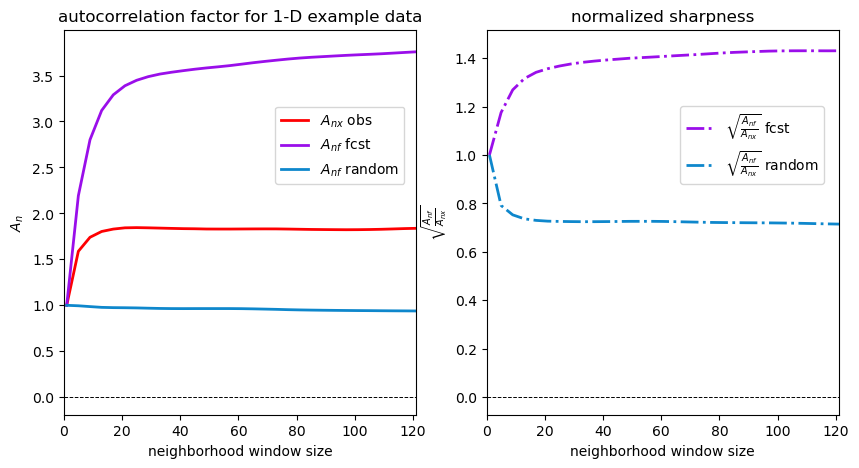

In [72]:
# autocorrelation factor in our 1-D example
fig,ax = plt.subplots(1,2,figsize=(10,5))
axs=ax.flat

s_x_2_0=np.var(obs1)
a_n_obs=sx_2*nwin/s_x_2_0
a_n_fcst=sf_2*nwin/s_x_2_0
a_n_rand=sf_2_rand*nwin/s_x_2_0
axs[0].plot(nwin,a_n_obs,c=colorlist[0],lw=2.,label=r'${A_{nx}}$ obs')
axs[0].plot(nwin,a_n_fcst,c=colorlist[1],lw=2.,label=r'${A_{nf}}$ fcst')
axs[0].plot(nwin,a_n_rand,c=colorlist[2],lw=2.,label=r'${A_{nf}}$ random')
axs[0].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.7)
axs[0].legend(loc=[0.6,0.6])
axs[0].set_xlabel('neighborhood window size')
axs[0].set_ylabel(r'$A_n$')
axs[0].set_title(r'autocorrelation factor for 1-D example data')
axs[0].set_xlim(0.,121.)

axs[1].plot(nwin,np.sqrt(a_n_fcst/a_n_obs),c=colorlist[1],lw=2.,ls='-.',label=r'$\sqrt{\frac{A_{nf}}{A_{nx}}}$ fcst')
axs[1].plot(nwin,np.sqrt(a_n_rand/a_n_obs),c=colorlist[2],lw=2.,ls='-.',label=r'$\sqrt{\frac{A_{nf}}{A_{nx}}}$ random')
axs[1].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.7)
axs[1].legend(loc=[0.55,0.6])
axs[1].set_xlabel('neighborhood window size')
axs[1].set_ylabel(r'$\sqrt{\frac{A_{nf}}{A_{nx}}}$')
axs[1].set_title(r'normalized sharpness')
axs[1].set_xlim(0.,121.)


### autocorrelation factor and normalized sharpness

Antonio and Aitchison (2025) derived expressions that showed how the variance of fractions produced by a binary field vary with neighborhood size and found those to be equal to the variance of the binary field (at the grid scale; $s_x^2[0]$) divided by the neighborhood size, multiplied by a factor that increased with increasing autocorrelation in the field. Using our notation, we should expect the observed variance to vary with neighborhood size as follows:

\begin{equation}
s_x^2[n]=s_x^2[0]\frac{A_{nx}}{N_w}=\bar x(1-\bar x)\frac{A_{nx}}{N_w}
\end{equation}

where $N_w$ is the neighborhood window size and $A_{nx}$ is the autocorrelation factor of the observed fractions at the n-th neighborhood. Antonio and Aitchison (2025) showed that the autocorrelation factor was equal to one ($A_{nx}=1$) if there was no autocorrelation in the field and increases with greater autocorrelation. 

The forecast fractions will follow a similar reduction in variance, with perhaps differing autocorrelation factors in the forecast fields.

\begin{equation}
s_f^2[n]=s_f^2[0]\frac{A_{nf}}{N_w}=\bar f(1-\bar f)\frac{A_{nf}}{N_w}
\end{equation}

In the special case where the forecasts are unbiased ($\bar f = \bar x$, $s_f^2[0]=s_x^2[0]$) the normalized sharpness at the grid scale will be equal to one and there will be a simple relationship between normalized sharpness and the square root of the ratio of autocorrelation factors as neighborhood windows increase in size:

\begin{equation}
s_f^2[n]=s_x^2[0]\frac{A_{nf}}{N_w}=\bar x(1-\bar x)\frac{A_{nf}}{N_w}
\end{equation}

\begin{equation}
\frac{s_f[n]}{s_x[n]}=\sqrt{\frac{A_{nf}}{A_{nx}}}
\end{equation}

The plots above show these autocorrelation factor for the 1-D example data, with the skillful forecast showing the highest autocorrelation, followed by the observations, then the randomly generated forecast with $A_{nf} \approx 1$. The resulting estimates of the normalized sharpness from the ratio of the autocorrelation factors (right subplot) matches the plot of the sharpness values in the previous section. For unbiased forecasts, analyzing the change in normalized sharpness with increasing neighborhood averaging window size provides information on the differences in multi-scale structure between the forecast and observed fields. When normalized sharpness is greater than 1, the forecast fractions are more "blocky"/less intermittent than the observed fractions, and vice versa.

## Centered Fractions Skill Score (CFSS)

To address these issues with FSS, a modified derivation of the fractions skill score based on the variance of forecast error will be presented as an alternative. Rather than using raw values of the forecasts and observations, in this alternate derivation forecast and observed variables will be “centered” by subtracting ther corresponding mean values, similar to how variables are centered in computations of variance and covariance. The centered mean square error of the fractions (Centered Fractions Brier Score) will be the base measure used to derive this alternate skill score. This is identical to calculating the variance of the forecast error, commonly used in the analysis of variance in linear regression. Taylor (2001) derived the geometric relationship between the centered MSE, variances of the observed and forecast fields, and correlation coefficient and showed how these could be combined on a single diagram (known as Taylor diagrams).

\begin{equation}
CFSS=1-\frac{\frac{1}{N}\sum((f_i-\bar f)-(x_i-\bar x))^2}{\frac{1}{N}\sum(f_i-\bar f)^2+\frac{1}{N}\sum(x_i-\bar x)^2}
=1-\frac{CFBS}{CFBS_{ref}}
\end{equation}

\begin{equation}
=1-\frac{\frac{1}{N}\sum(f_i-\bar f)^2+\frac{1}{N}\sum(x_i-\bar x)^2-\frac{2}{N}\sum{(f_i-\bar f)(x_i-\bar x)}}{\frac{1}{N}\sum(f_i-\bar f)^2+\frac{1}{N}\sum(x_i-\bar x)^2}
=1-\frac{s_f^2+s_x^2-2s_{fx}}{s_f^2+s_x^2}=\frac{2s_{fx}}{s_f^2+s_x^2}=HM(\frac{s_{fx}}{s_f^2},\frac{s_{fx}}{s_x^2})
\end{equation}
\begin{equation}
CFBS=s_f^2+s_x^2-2s_{fx}
\end{equation}
\begin{equation}
CFBS_{ref}=s_f^2+s_x^2
\end{equation}

In this CFSS derivation, the reference forecast has zero covariance with the observations, which is what is expected from a randomly-generated forecast. We should expect to find $CFSS \approx 0$ for random forecasts, which will be the "no skill" baseline for this score. Similar to how FSS can be expressed as a harmonic mean, we find that CFSS is the harmonic mean of the forecast/observation covariance, normalized by the variances of the forecasts and observations. 

To understand the scale-dependent behavior of this measure we will rewrite the expression in terms of correlation coefficient and normalized sharpness (below) and consider the general behavior of these components with increasing neighborhood size. Unlike FSS, there is no "random" term, CFSS has a single term that is the product of the correlation coefficient and a normalized sharpness factor. While we anticipate that correlation may increase with larger neighborhoods for skillful forecasts, that will not always be the case. In addition, we found in the 1-D example that sharpness can either increase or decrease with increasing neighborhood scale, but in general is bounded in a relatively small range and nearly constant, especially as the neighborhood window sizes get large. In that case we will find the CFSS to be directly proportional to correlation, without the undesirable scale-dependent asymptotic behavior found in FSS.
\begin{equation}
CFSS=r_{fx}\frac{2s_f/s_x}{(s_f/s_x)^2+1}
\end{equation}

(0.0, 121.0)

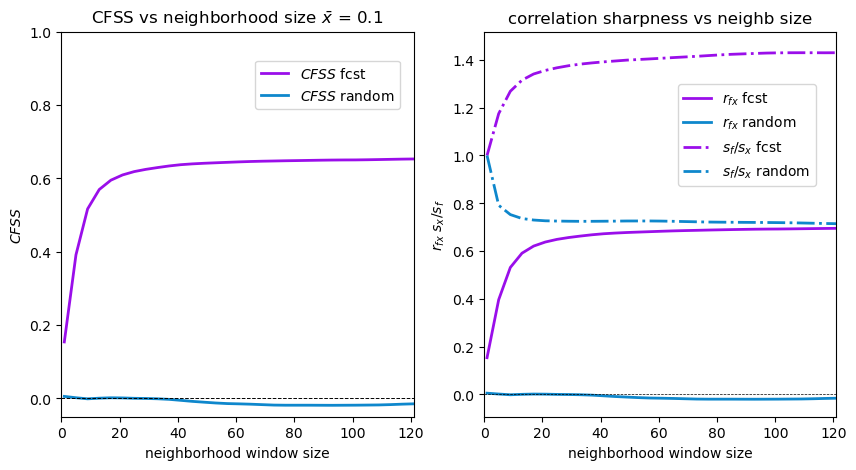

In [77]:
# CFSS on the left subplot, correlation and normalized sharpness on the right subplot

cfss=2.*rfx1*np.sqrt(sf_2/sx_2)/(sf_2/sx_2+1.)
cfss_rand=2.*rfx2*np.sqrt(sf_2_rand/sx_2_rand)/(sf_2_rand/sx_2_rand+1.)

fig,ax = plt.subplots(1,2,figsize=(10,5))
axs=ax.flat
axs[0].plot(nwin,cfss,c=colorlist[1],lw=2.,label=r'$CFSS$ fcst')
axs[0].plot(nwin,cfss_rand,c=colorlist[2],lw=2.,label=r'$CFSS$ random')
axs[0].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.7)
axs[0].legend(loc=[0.55,0.8])
axs[0].set_xlabel('neighborhood window size')
axs[0].set_ylabel(r'$CFSS$')
axs[0].set_title(r'CFSS vs neighborhood size $\bar x$ ='+f' {np.round(xbar,2)}')
axs[0].set_xlim(0.,121.)
axs[0].set_ylim(-0.05,1.)

axs[1].plot(nwin,rfx1,c=colorlist[1],lw=2.,label=r'$r_{fx}$ fcst')
axs[1].plot(nwin,rfx2,c=colorlist[2],lw=2.,label=r'$r_{fx}$ random')
axs[1].plot(nwin,np.sqrt(sf_2)/np.sqrt(sx_2),c=colorlist[1],lw=2.,ls='-.',label=r'$s_f$/$s_x$ fcst')
axs[1].plot(nwin,np.sqrt(sf_2_rand)/np.sqrt(sx_2_rand),c=colorlist[2],lw=2.,ls='-.',label=r'$s_f$/$s_x$ random')

axs[1].plot([0.,400.],[0.,0.],c='k',ls='--',lw=0.5)
axs[1].legend(loc=[0.55,0.6])
axs[1].set_xlabel('neighborhood window size')
axs[1].set_ylabel(r'$r_{fx}$ $s_x$/$s_f$')
axs[1].set_title(r'correlation sharpness vs neighb size')
axs[1].set_xlim(0.,121.)



### CFSS 1-D example

We find that CFSS behaves in a similar fashion as the correlation coefficent. For the skillful forecast, CFSS increases sharply as the neighborhood size increases from the initial grid scale, reaching a plateau for windows greater than ~40 grid points in size. CFSS for the random forecast remains near zero, as expected.

## recommendation for displaying CFSS

Since CFSS is a function of correlation ($r_{fx}$) and normalized sharpness ($s_f$/$s_x$), we recommend plotting both of those components to get a more complete picture of the mulit-scale forecast performance (as shown in Antonio and Aitchison 2025). These components can be used to define a 2-D space in which the scores can be displayed, much like the Taylor diagram displays MSE, correlation, and variances in a single diagram.

\begin{equation}
CFSS=r_{fx}\frac{2s_f/s_x}{(s_f/s_x)^2+1}
\end{equation}

Another widely-used MSE-based skill score will be included for comparison purposes, the Brier skill score (BSS). The typical reference forecast used for BSS is a constant unbiased forecast ($f_i=\bar x$), therefore $MSE_{ref}=s_x^2$.

\begin{equation}
BSS=1-\frac{MSE}{MSE_{ref}}=\frac{2 s_{fx} - s_f^2-(\bar f - \bar x)^2}{s_x^2}
\end{equation}

For this comparison we'll assume the forecasts are unbiased (so we can drop the bias term in the numerator):

\begin{equation}
BSS_{\bar f = \bar x}=\frac{2 s_{fx} - s_f^2}{s_x^2}=2 r_{fx} \frac{s_f}{s_x} - \frac{s_f^2}{s_x^2}
\end{equation}

Contours/colorfills of CFSS and BSS can be plotted in the background of this 2-D space, examples are provided in the code below:

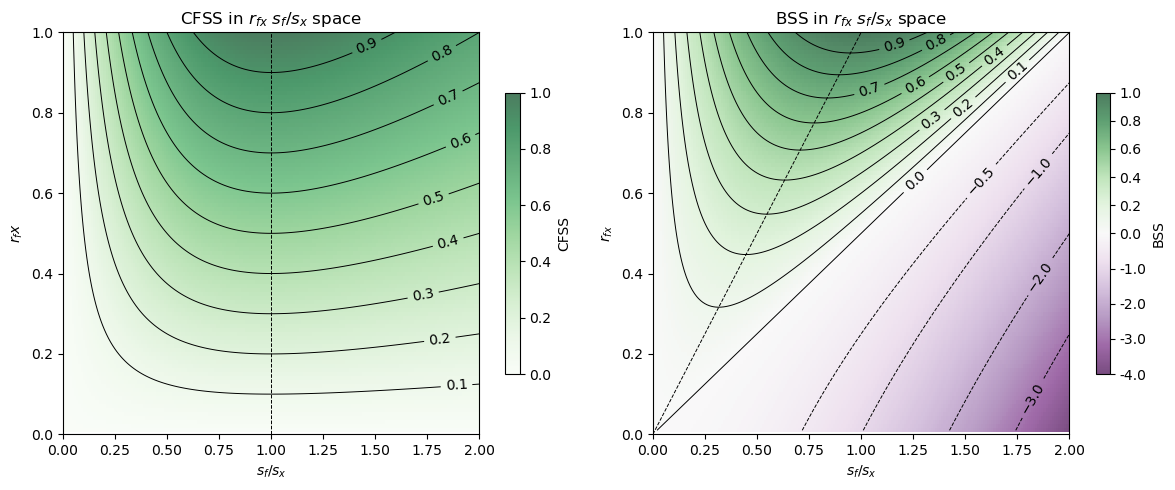

In [80]:
Ans=[1.,1.85,2.0,2.0]
#S=2.0
xbar=0.2
xodd=(1.-xbar)/xbar

fig, axs = plt.subplots(1, 2,figsize=(12,5))
axs = axs.flat
x1d=np.linspace(0.01,2.0,200)
y1d=np.linspace(0.01,1.0,100)
xx,yy=np.meshgrid(x1d,y1d)


cfss=(2.*yy*xx)/(xx*xx+1.)
sc1=axs[0].pcolormesh(xx,yy,cfss,cmap='Greens',vmin=0.,vmax=1.,alpha=0.7)
cs1=axs[0].contour(xx,yy,cfss,levels=np.linspace(0.0,1.0,11),colors='k',linewidths=0.7)
axs[0].clabel(cs1, cs1.levels, inline=True, fontsize=10)
plt.colorbar(sc1,orientation='vertical',shrink=0.7,label='CFSS',ax=axs[0])
axs[0].set_title(r'CFSS in $r_{fx}$ $s_f/s_x$ space')
axs[0].set_xlabel(r'$s_f/s_x$')
axs[0].set_ylabel(r'$r_fx$')
axs[0].plot([1.,1.],[0.,1.],'k--',lw=0.7)

axs[0].set_ylim(0.,1.)
axs[0].set_xlim(0.,2.)

bss=2.*yy*xx-xx*xx
sc1=axs[1].pcolormesh(xx,yy,bss,cmap='PRGn',alpha=0.7,norm=colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=1.))
cs1=axs[1].contour(xx,yy,bss,levels=[-4.,-3.,-2.,-1.,-0.5,0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.],colors='k',linewidths=0.7)
axs[1].clabel(cs1, cs1.levels, inline=True, fontsize=10)
cbar=plt.colorbar(sc1,orientation='vertical',shrink=0.7,label='BSS',ax=axs[1])
ticks=[-4.,-3.,-2.,-1.,0.,0.2,0.4,0.6,0.8,1.]
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(t) for t in ticks])
axs[1].set_title(r'BSS in $r_{fx}$ $s_f/s_x$ space')
axs[1].plot([0.,1.],[0.,1.],'k--',lw=0.7)
axs[1].set_xlabel(r'$s_f/s_x$')
axs[1].set_ylabel(r'$r_{fx}$')
axs[1].set_ylim(0.,1.)
axs[1].set_xlim(0.,2.)

plt.tight_layout()

## Appendix: Grid scale (binary) FSS/CFSS equivalent scores from 2x2 contingency table

At the finest/grid scale the forecasts and observations are binary when calculating FSS (or CFSS). We can use the decompositions of these scores to show that FSS and CFSS can be expressed in terms of commonly-used scores from the 2x2 contingency table. Rewriting these scores in terms of forecast/observation moments:

\begin{equation}
E[x^2]=\frac{1}{N}\sum(x_i)^2=s_x^2+{\bar x}^2
\end{equation}

\begin{equation}
E[f^2]=\frac{1}{N}\sum(f_i)^2=s_f^2+{\bar f}^2
\end{equation}

\begin{equation}
E[fx]=\frac{1}{N}\sum(f_1 x_i)=s_{fx}+\bar f \bar x
\end{equation}

\begin{equation}
FSS=\frac{2\frac{1}{N}\sum(f_i x_i)}{\frac{1}{N}\sum(f_i)^2+\frac{1}{N}\sum(x_i)^2}
=\frac{2E[fx]}{E[f^2]+E[x^2]}=HM(\frac{E[fx]}{E[f^2]},\frac{E[fx]}{E[x^2]})
\end{equation}

\begin{equation}
CFSS=\frac{2\frac{1}{N}\sum{(f_i-\bar f)(x_i-\bar x)}}{\frac{1}{N}\sum(f_i-\bar f)^2+\frac{1}{N}\sum(x_i-\bar x)^2}
=HM(\frac{s_{fx}}{s_f^2},\frac{s_{fx}}{s_x^2})=HM(\frac{E[fx]-\bar f \bar x}{E[f^2]-{\bar f}^2},\frac{E[fx]-\bar f \bar x}{E[x^2]-{\bar x}^2})
\end{equation}

FSS can be written as the harmonic mean of the product moment of the forecasts and observations normalized by the second moments of the forecasts or observations. CFSS can be expressed as the harmonic mean of the covariance of the forecasts and observations normalized by the variances of the forecasts or observations. The elements of the 2x2 contingency table can also be expressed in terms of these moments. Since the forecasts and observations are binary, their second moments are equal to their first moments (means), which are found in the column/row sums of the 2x2 contingency table. The product moment of the forecasts and observations is equal to the “a” element (proportion of correct “yes” forecasts) of the 2x2 contingency table. 

### 2x2 contingency table


| |obs=yes|obs=no|sum|
|:---:|:---:|:---:|:---:|
|fcst=yes|a|b|a+b=$\bar f$|
|fcst=no|c|d|c+d=$1-\bar f$|
| |a+c=$\bar x$|b+d=$1-\bar x$|1|

2x2 contingency table for dichotomous forecasts of observed events, expressed in terms of proportions or relative frequencies. The “a” element of the contingency table provides the proportion of correct “yes” forecasts, often referred to as “true positives” or “hits”. The “b” element provides the proportion of incorrect “yes” forecasts, also known as “false positives” or “false alarms”. The “c” element provides the proportion of incorrect “no” forecasts, also denoted as “false negatives” or “missed events”. The “d” element provides the proportion of correct “no” forecasts, also called “true negatives” or “correct nulls”. 

\begin{equation}
E[x^2]=\frac{1}{N}\sum(x_i)^2=\frac{1}{N}\sum x_i=a+c
\end{equation}

\begin{equation}
E[f^2]=\frac{1}{N}\sum(f_i)^2=\frac{1}{N}\sum f_i=a+b
\end{equation}

\begin{equation}
E[fx]=\frac{1}{N}\sum(f_1 x_i)=a
\end{equation}

### common scores from the 2x2 contingency table

#### probability of detection (POD)
$POD=\frac{a}{a+c}$
#### success ratio (SR)
$SR=\frac{a}{a+b}$
#### probability of false detection (POFD)
$POFD=\frac{b}{b+d}$
#### miss ratio (MR)
$MR=\frac{c}{c+d}$
#### Peirce skill score (PSS)
$PSS=POD-POFD=\frac{a}{a+c}-\frac{b}{b+d}$
#### Clayton skill score (CSS)
$CSS=SR-MR=\frac{a}{a+b}-\frac{c}{c+d}$

### FSS for binary forecast = F1 score

For binary forecasts (grid scale), we find that FSS is the harmonic mean of success ratio (SR) and probability of detection (POD). The harmonic mean of POD and SR (recall and precision) is more commonly known as the F measure, F1 score, or Sorensen-Dice coefficient (Brooks et al. 2025)

\begin{equation}
FSS=\frac{2E[fx]}{E[f^2]+E[x^2]}=\frac{2a}{2a+b+c}=HM(\frac{a}{a+b},\frac{a}{a+c})
=HM(SR,POD)=F1
\end{equation}

Note the similarity to the critical success index (CSI) which was originally derived as the “ratio of verification” by Gilbert (1884).

\begin{equation}
CSI=\frac{a}{a+b+c}
\end{equation}

\begin{equation}
F1=\frac{2(CSI)}{CSI+1}
\end{equation}

At the grid scale, when binary forecasts are unbiased ($\bar f=\bar x$, such as when consistent percentile thresholds are used) the success ratio is equal to the probability of detection, therefore FSS=POD:
\begin{equation}
FSS_{\bar f=\bar x}=POD
\end{equation}

### CFSS for binary forecast = harmonic mean of Peirce and Clayton skill scores

We also find that the binary version of CFSS is the harmonic mean of two skill scores from the 2x2 contingency table, the Clayton skill score (CSS, Clayton 1888) and the Peirce skill score (PSS, Peirce 1885). To the authors’ knowledge, this score has not been used in weather forecast evaluation, but according to Brusco et al. (2021) is equivalent to a score derived by Maxwell and Pilliner (1968).

\begin{equation}
CFSS=HM(\frac{E[fx]-\bar f \bar x}{E[f^2]-{\bar f}^2},\frac{E[fx]-\bar f \bar x}{E[x^2]-{\bar x}^2})
=HM(\frac{ad-bc}{(a+b)(c+d)},\frac{ad-bc}{(a+c)(b+d)})=HM(CSS,PSS)
\end{equation}
\begin{equation}
CFSS=\frac{2(ad-bc)}{(a+b)(c+d)+(a+c)(b+d)}
\end{equation}

At the grid scale, when binary forecasts are unbiased ($\bar f=\bar x$, such as when consistent percentile thresholds are used) the CSS and PSS are equivalent, therefore CFSS=PSS:
\begin{equation}
CFSS_{\bar f=\bar x}=PSS=POD-POFD
\end{equation}